<a href="https://colab.research.google.com/github/gannannavelorange/575/blob/master/src/IB_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!git clone https://github.com/gannannavelorange/575

Cloning into '575'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 638 (delta 47), reused 0 (delta 0), pack-reused 548
Receiving objects: 100% (638/638), 3.39 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (271/271), done.


In [43]:
cd 575/src/data_IB_project

/content/575/src/data_IB_project/575/src/data_IB_project


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import t

# VaR and ES

In [0]:
#VaR
def VaRnorm(alpha,mu,sigma):
  VaR=mu+sigma*norm.ppf(alpha)
  ES=mu+sigma*norm.pdf(norm.ppf(alpha))/(1-alpha)
  return VaR,ES


In [0]:
def VaRt(alpha,mu,sigma,v):
  VaR=mu+sigma*t.ppf(alpha,v)
  E=t.pdf(t.ppf(alpha,v),v)/(1-alpha)*(v+(t.ppf(alpha,v))**2)/(v-1)
  ES=mu+sigma*E
  return VaR,ES

# Stock&ETF

In [0]:
#using WEEKLY log return
names=['CAT','DIA','HD','MSFT','NKE','NVDA','PG','TM','VIG','VOO','WMT','GOOG','CHEF','SPB','ORCL']
def getData(N):  
    mu=np.zeros(15)
    Is=[i for i in range(15)]
    Rows=[]
    for name,i in zip(names,Is):
        with open(name+'.csv') as file:
            reader=csv.reader(file)
            rows=[row[2] for row in reader] 
        mu[i]=np.mean([float(row) for row in rows[1+N:53+N]]) #mean
        Rows.append([float(row) for row in rows[1+N:53+N]])
    Sigma=np.cov(np.array(Rows)) #covariance matrix
    return mu,Sigma,rows

In [0]:
def getdata1(M,N):
  with open(M+'.csv') as file:
      reader=csv.reader(file)
      rows=[row for row in reader]
      col0=[row[0] for row in rows[1:62]]
      col0=[float(c) for c in col0] # port value
      #col1=[row[1] for row in rows[1+N:53+N]]
      col1=[row[1] for row in rows[1+N:52+N]]
      col1=[float(c) for c in col1]  # port loss
      
  return col0,col1

In [0]:
#linearized loss mean&variance
def lin_loss(Vt,Wt,mu,omega):
  mean=-Vt*(np.dot(Wt,mu))
  variance=(Vt**2)*(np.dot(np.dot(Wt,omega),Wt))
  return mean,variance

In [0]:
#rolling window for linearized loss assuming log return change follows Normal distribution 
def stock_norm():
  MU=[]
  VAR=[]
  for i in range(0,10):
    data= getData(i+1)
    mu=data[0]
    Sigma=data[1]
    vt=getdata1('PORT_VALUE',i)[0]
    wt=np.ones(15)*(1/15)
    linloss=lin_loss(vt[i+51]*400000,wt,mu,Sigma)
    MU.append(linloss[0])
    VAR.append(linloss[1])
  return MU,VAR
 #print(MU)
 #print(VAR)

In [0]:
#rolling window  assuming portfolio loss follows t distribution 
def stock_t():
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    data=np.array(getdata1('PORT_VALUE',i)[1])*400000
    T=t.fit(data)
    df.append(T[0])
    mu.append(T[1])
    sigma.append(T[2])
  return df,mu,sigma
#print(T_df)
#print(T_mu)
#print(T_sigma)

In [0]:
# plot VaR and ES vs time
def plot_N(name):
  N1=VaRnorm(0.9,name[0],np.sqrt(name[1]))
  N2=VaRnorm(0.95,name[0],np.sqrt(name[1]))
  N3=VaRnorm(0.99,name[0],np.sqrt(name[1]))
  #x=np.linspace(1,10,10)
  x=['2020/02/14','2020/02/21','2020/02/28','2020/03/06','2020/03/13','2020/03/20','2020/03/27','2020/04/3','2020/04/10','2020/04/17']
  plt.plot(x,N1[0],'orange',label="VaR_0.9")
  plt.plot(x,N1[1],'blue',label="ES_0.9")
  plt.plot(x,N2[0],'yellow',label="VaR_0.95")
  plt.plot(x,N2[1],'green',label="ES_0.95")
  plt.plot(x,N3[0],'red',label="VaR_0.99")
  plt.plot(x,N3[1],'purple',label="ES_0.99")
  plt.xlabel('time')
  plt.xticks(rotation=45)
  #plt.title('Normal:stock&ETF:var and ES vs time')
  #plt.title('Normal:Put option DJX:var and ES vs time')
  #plt.title('Normal:Call option CAT:var and ES vs time')
  #plt.title('Normal:Call option VIG:var and ES vs time')
  #plt.title('Normal:Bond20-year:var and ES vs time')
  #plt.title('Normal:Bond30-year:var and ES vs time')
  #plt.title('Normal:Bond portfolio:var and ES vs time')
  #plt.title('Normal:Option portfolio:var and ES vs time')
  plt.title('Portfolio var and ES vs time with normal distribution')
  plt.legend()
  plt.show()
  return N1[0],N1[1],N2[0],N2[1],N3[0],N3[1]
  
def plot_T(name):
  N1_var=[]
  N1_es=[]
  N2_var=[]
  N2_es=[]
  N3_var=[]
  N3_es=[]
  for i in range(0,10):
    T1=VaRt(0.9,name[1][i],name[2][i],name[0][i])
    T2=VaRt(0.95,name[1][i],name[2][i],name[0][i])
    T3=VaRt(0.99,name[1][i],name[2][i],name[0][i])
    N1_var.append(T1[0])
    N1_es.append(T1[1])
    N2_var.append(T2[0])
    N2_es.append(T2[1])
    N3_var.append(T3[0])
    N3_es.append(T3[1])
  #x=np.linspace(1,10,10)
  x=['2020/02/14','2020/02/21','2020/02/28','2020/03/06','2020/03/13','2020/03/20','2020/03/27','2020/04/3','2020/04/10','2020/04/17']
  plt.plot(x,N1_var,'orange',label="VaR_0.9")
  plt.plot(x,N1_es,'blue',label="ES_0.9")
  plt.plot(x,N2_var,'yellow',label="VaR_0.95")
  plt.plot(x,N2_es,'green',label="ES_0.95")
  plt.plot(x,N3_var,'red',label="VaR_0.99")
  plt.plot(x,N3_es,'purple',label="ES_0.99")
  plt.xlabel('time')
  plt.xticks(rotation=45)
  #plt.title('T:stock&ETF:var and ES vs time')
  #plt.title('T:Put option DJX:var and ES vs time')
  #plt.title('T:Call option CAT:var and ES vs time')
  #plt.title('T:Call option VIG:var and ES vs time')
  #plt.title('T:Bond20-year:var and ES vs time')
  #plt.title('T:Bond30-year:var and ES vs time')
  #plt.title('T:Bond portfolio:var and ES vs time')
  plt.title('Portfolio var and ES vs time with t distribution')
  plt.legend()
  plt.show()
  return N1_var,N1_es,N2_var,N2_es,N3_var,N3_es

([-2184.4121072601165, -1089.562834286747, -1128.2445046939927, 99.03518540788191, 1772.40067129909, 529.4705256889033, 962.2148752578879, 217.8220329882339, 104.49368198248186, 110.41358889778817], [78737101.1392646, 142247199.01808247, 112670241.3850035, 163344498.2689849, 283187350.1667939, 264175762.94001532, 337332841.377919, 364350910.5106507, 436534407.8471075, 483075639.10686916])


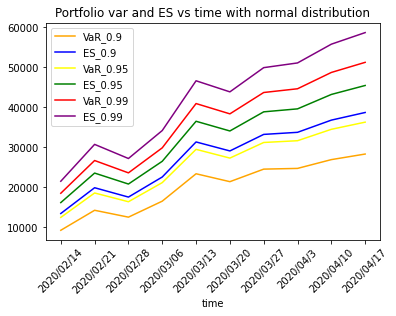

(array([ 9187.29842521, 14195.17335232, 12474.94342312, 16478.07132349,
       23338.56997899, 21359.14921153, 24499.98936795, 24680.05033622,
       26880.47065353, 28277.6120696 ]), array([13388.24437667, 19841.67221623, 17500.2434507 , 22528.82730753,
       31305.56064263, 29054.06494965, 33195.33191816, 33716.90531602,
       36772.07242566, 38683.15994947]), array([12411.02034888, 18528.18367663, 16331.25818154, 21121.30047852,
       29452.27931132, 27264.07368626, 31172.62137437, 31614.75215244,
       34471.0880672 , 36262.62144981]), array([16118.84902497, 23511.88274085, 20766.67624296, 26461.80397675,
       36484.08519173, 34055.74145907, 38847.28342158, 39590.83906785,
       43201.58951305, 45446.74075655]), array([18458.18654632, 26656.19042993, 23565.06333158, 29831.22616632,
       40920.58125881, 38340.72996352, 43689.36930502, 44623.09946194,
       48709.82395338, 51241.17107459]), array([21465.08076968, 30697.76225977, 27162.00216349, 34162.15149256,
       46623.

In [13]:
N=stock_norm()
print(N)
a=plot_N(N)
print(a)


([327999.9530839643, 307000.6903773176, 270876.1232850582, 3.0724854510577497, 2.9254948158665774, 2.276186626506002, 1.865014168189391, 1.6492828567546036, 1.7227334599156419, 1.6416490529732188], [-1923.8936145052676, -2158.9701912437704, -2071.2347988305482, -2620.625417418308, -2375.642686790336, -2475.7776225730267, -2400.0611139562225, -2292.358390978403, -1960.1454713731414, -1891.548941568749], [7361.323257080614, 7486.484960402515, 7535.714356590681, 6130.290850359383, 5907.619702081753, 5905.8412507339335, 5971.332959497877, 5935.0138675269045, 6191.671676005527, 6436.750680082552])


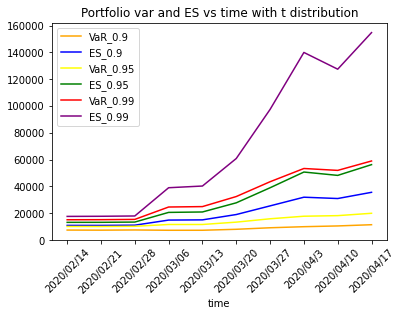

([7510.040730079684, 7435.366974954244, 7586.19528421639, 7355.629613251798, 7366.418030127406, 8088.96314112003, 9227.553660593789, 10026.661587998631, 10589.674564037976, 11503.808959919454], [10995.15162882007, 10979.735709914168, 11153.874865832646, 14952.976596609144, 15110.223047308253, 19091.20697127442, 25539.012862539894, 32010.540935300913, 31023.618709150087, 35654.34536211459], [10184.439842208514, 10155.238907571062, 10323.95468334735, 11668.473964376555, 11672.674666694342, 13423.605389474964, 15928.015439897916, 17832.140818633838, 18268.89926627852, 20023.536005919796], [13260.46818811079, 13283.569975093751, 13472.861577090678, 20681.8643490526, 20993.493078811403, 27825.835979907977, 39047.93778639552, 50767.40177494676, 48269.15612150412, 56284.208817646824], [15201.188786967163, 15257.289117674743, 15459.5620166185, 24696.88744668815, 25003.063905957544, 32509.093736983363, 43541.14327594565, 53409.43390407908, 51999.79883631856, 59012.90912775594], [17695.735611225

In [14]:
T=stock_t()
print(T)
b=plot_T(T)
print(b)


# Options

In [0]:
def getdata2(M,N):
  with open(M+'.csv') as file:
      reader=csv.reader(file)
      rows=[row for row in reader]
      col0=[row[1] for row in rows[1:62]]
      col0=[float(c) for c in col0] # stock value
      col1=[row[2] for row in rows[1+N:53+N]]
      col1=[float(c) for c in col1]  # log return
      col2=[row[3] for row in rows[1+N:53+N]]
      col2=[float(c) for c in col2]  # net stock return
  return col0,col1,col2


In [0]:
def origin_price(S,K,r,sigma,t):
  d1=(np.log(S/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  d2=d1-sigma*np.sqrt(t)
  callprice=S*norm.cdf(d1)-K*np.exp(-r*t)*norm.cdf(d2)
  putprice=-S*norm.cdf(-d1)+K*np.exp(-r*t)*norm.cdf(-d2)
  return callprice,putprice

In [0]:
def delta(S,K,r,sigma,t):
  d1=(np.log(S/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  delta_C=norm.cdf(float(d1))
  delta_P=norm.cdf(float(d1))-1
  return delta_C,delta_P


In [0]:
#OP=[9.5,9,11.21,39.96,38.84,64.99,102.26,78.84,83.26,57.34,51.95] 

In [19]:
'''
def option_N(M,K,share,type,t):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  MU=[]
  VAR=[]
  L=[]
  d=[]
  op=[]
  LL=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    #loss=(-1)**(type)*np.array(data[2]) #stock loss
    vt=data[0]
    wt=1
    linloss=lin_loss(vt[i+51]*share,wt,mu,variance)
    OP=origin_price(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]  #t=(2020/06/18-2020/02/14)/250
    Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    MU.append((-1)**(type+1)*leverage*linloss[0])
    VAR.append(leverage**2*linloss[1])
    L.append(leverage)
    d.append(Delta)
    op.append(OP)
    LL.append(linloss[1])
  return MU,VAR,d,op,L,LL

SyntaxError: ignored

In [0]:

def option_N(M,K,share,type,t):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  MU=[]
  VAR=[]
  Loss=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    #loss=(-1*share)**(type)*np.array(data[2]) #stock loss
    #Norm=norm.fit(loss)
    vt=data[0]
    wt=1
    #linloss=lin_loss(vt[i+51]*share,wt,mu,variance)
    OP=origin_price(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type] #t=(2020/06/18-2020/02/14)/250
    OP1=origin_price(vt[i+51-1],K,0.02,0.1,(t+7-7*i)/250)[type]
    loss=(OP1-OP)*((-1)**(type+1))
    Loss.append(loss)
    Norm=norm.fit(Loss)
    #Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    #leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    MU.append(Norm[0])
    VAR.append(Norm[1])
    
  return MU,VAR

In [0]:
def option_T(M,K,share,type,T):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  DF=[]
  MU=[]
  VAR=[]
  Loss=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    #loss=(-1*share)**(type)*np.array(data[2]) #stock loss
    #Norm=norm.fit(loss)
    vt=data[0]
    wt=1
    #linloss=lin_loss(vt[i+51]*share,wt,mu,variance)
    OP=origin_price(vt[i+51],K,0.02,0.1,(T-7*i)/250)[type] #t=(2020/06/18-2020/02/14)/250
    OP1=origin_price(vt[i+51-1],K,0.02,0.1,(T+7-7*i)/250)[type]
    loss=(OP1-OP)*((-1)**(type+1))
    Loss.append(loss)
    Norm=t.fit(Loss)
    #Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    #leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    DF.append(Norm[0])
    MU.append(Norm[1])
    VAR.append(Norm[2])
    
  return DF,MU,VAR

In [0]:
djx=option_N('DIA',293,100,1,125)
c=plot_N(djx)
print(c)


In [0]:
cat=option_N('CAT',135,200,0,91)
d=plot_N(cat)
print(d)

In [0]:
vig=option_N('VIG',131,200,0,91)
e=plot_N(vig)
print(e)

In [0]:
'''
def option_t(M,K,share,type,t):
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    nr=np.array(data[2])*share
    T=ss.t.fit(nr)
    #df.append(T[0])
    #mu.append(T[1])
    #sigma.append(T[2])
    vt=data[0]
    wt=1
    OP=origin_price(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]  #t=(2020/06/18-2020/02/14)/250
    Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    df.append(T[0])
    mu.append((-1)**(type+1)*leverage*T[1])
    sigma.append(leverage**2*T[2])
    #L.append(leverage)
    #d.append(Delta)
    #op.append(OP)

  return df,mu,sigma

In [0]:
vig2=option_T('VIG',131,200,0,91)
e=plot_T(vig2)


In [0]:
a=getdata2('VIG',0)[2]
b=np.array(a)*200
print(b)


**option portfolio**

In [0]:

def option_portfolio(M,K,share,type,t):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  MU=[]
  VAR=[]
  L=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    vt=data[0]
    wt=1
    Loss=[]
    for j in range(0,51):
      OP=origin_price(vt[j+i+1],K,0.02,0.1,(t-7*i)/250)[type] #t=(2020/06/18-2020/02/14)/250
      OP1=origin_price(vt[j+i],K,0.02,0.1,(t+7-7*i)/250)[type]
      loss=(OP1-OP)*share*((-1)**(type+1))
      Loss.append(loss)
    L.append(Loss)
   
    
  return L

In [0]:
DJX=option_portfolio('DIA',293,100,1,125)
CAT=option_portfolio('CAT',135,200,0,91)
VIG=option_portfolio('VIG',131,200,0,91)
SP=option_portfolio('SP500',2270,100,1,125)
def OptionPort_N():
  mu=[]
  variance=[]
  for i in range(0,10):
    option_loss=DJX[i]+CAT[i]+VIG[i]
    #op_loss.append(option_loss)
    Norm=norm.fit(option_loss)
    mu.append(Norm[0])
    variance.append(Norm[1]**2)
  return mu, variance
 

In [0]:
print(DJX[0])

In [0]:
def OptionPort_T():
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    option_loss=DJX[i]+CAT[i]+VIG[i]
    #op_loss.append(option_loss)
    Norm=ss.t.fit(option_loss)
    df.append(Norm[0])
    mu.append(Norm[1])
    sigma.append(Norm[2])
  return df,mu,sigma

([15.242650902113887, 13.017335799177207, -7.735230311582984, -7.913028543303331, -22.54382259533524, -52.00805876057212, -41.331332399529366, -45.15541101390568, -30.99274433193551, -23.12447554881127], [89044.61917574238, 89416.12785585104, 144056.87636098432, 144818.4002359496, 190530.95540776267, 290998.635197534, 329437.98480114253, 332689.7628230722, 379615.25239750807, 380995.9491228951])


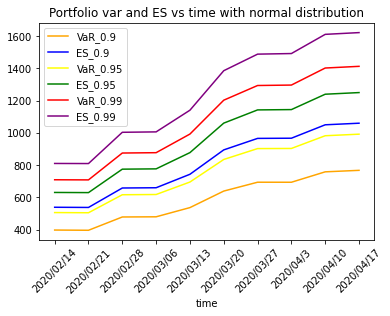

(array([397.66205985, 396.23367247, 478.67542753, 479.78158429,
       536.85153532, 639.31582575, 694.23682734, 694.03411451,
       758.60866026, 767.91155341]), array([ 538.93572868,  537.80174295,  658.3656226 ,  659.94609899,
        743.50379378,  894.70522082,  965.9709762 ,  967.10607108,
       1050.30381153, 1060.1366847 ]), array([506.07264849, 504.87017905, 616.56609025, 618.03623042,
       695.43234637, 835.29654092, 902.76017975, 903.5840738 ,
       982.44968679, 992.15927601]), array([ 630.76326973,  629.82064434,  775.16381223,  777.05259523,
        877.82725903, 1060.70770629, 1142.59751188, 1144.60217851,
       1239.90495021, 1250.08230911]), array([ 709.43288321,  708.65419824,  875.22604117,  877.37895366,
        992.90357462, 1202.92376938, 1293.91530973, 1296.66494756,
       1402.33822596, 1412.81070938]), array([ 810.55177015,  809.98380787, 1003.84217091, 1006.33458526,
       1140.81823227, 1385.72281169, 1488.41337087, 1492.12056595,
       1611.12369367

In [52]:
optionN=OptionPort_N()
print(optionN)
OP1=plot_N(optionN)
print(OP1)

In [0]:
optionT=OptionPort_T()
print(optionT)
OP2=plot_T(optionT)
print(OP2)

# Bonds

In [0]:
c1=1.75/100*1000/2
c2=6/100*1000/2
n1=15
n2=11
#r=-0.115/100
#r=-0.098/100/2
F=1000

In [0]:
def getdata3(M):
  with open(M+'.csv') as file:
      reader=csv.reader(file)
      rows=[row for row in reader]
      col0=[row[1] for row in rows[1:62]]
      col0=[float(c) for c in col0]  # weekly interest rate 
      
  return col0

In [0]:
def bond(C,r,F,t,N):
  price=C*np.exp(-t/182*r)*(1-np.exp(-(N+1)*r))/(1-np.exp(-r))+F*np.exp((-t/182+N)*r)
  return price

In [0]:
price1=[]
ir=getdata3('bond1')
for i in range(0,62):
  #price1.append(price(c1,ir[i]/200,F,365+152-7*i,n1))
   price1=bond(c1,ir[i]/200,F,365+152-7*i,n1)
   print(price1)


In [0]:
price2=[]
ir2=getdata3('bond3.625')
for i in range(0,62):
  #price1.append(price(c2,ir2[i]/200,F,365+182-7*i,n2))
   price2=bond(c2,ir2[i]/200,F,365+182-7*i,n2)
   print(price2)

In [0]:
change1=[-4.668573138,4.682383382,4.349368188,5.835342088,0.335362367,-3.382900463,-0.131487767,-1.115815597,4.503941318,-5.008539069,1.972199344,0.576278395,0.581172825,9.154902473,2.954096239,-6.427463478,7.629812859,0.460874008,-2.198163134,1.113738061,1.418586252,-2.578652906,5.261678406,7.583518091,3.659731396,0.939440513,1.898128387,-3.714462234,-14.00055823,5.45632942,-0.230696157,8.103933568,-10.0557118,1.9341998,0.077755178,0.95285408,-5.132561839,0.697867622,3.54908232,-0.806211355,1.859109537,2.058610119,-1.949638607,0.215822686,7.900428318,-3.600754927,0.039736232,7.05675355,8.187982161,-2.85099818,1.046100019,4.51903132,7.903259478,13.16607817,-51.70245549,-20.28135685,45.34336564,14.75785748,3.49401862,-7.470250461]
change2=[-2.343005668,1.945113295,1.972822876,2.542413215,0.122604735,-1.530576473,-0.161477869,-0.726925837,2.110371946,-2.444152538,0.704994944,0.426503005,0.141454991,4.577723799,1.369595132,-3.684086465,4.094275231,-0.089582705,-1.00584495,0.518844644,0.838385274,-1.336294992,2.74008262,4.020882524,2.166658856,0.298004241,0.93958902,-1.936582133,-7.566860295,2.57674102,-0.063134362,4.292829791,-5.43881714,0.956566778,-0.063146019,0.631160615,-2.862976108,0.275208311,2.41418133,-0.415465755,0.659689401,1.030872752,-1.141328612,-0.055231276,4.735420611,-2.241739646,-0.036754951,3.711281031,4.85212206,-1.477834969,0.391437357,2.295328699,5.722459023,7.979227515,-30.52251217,-11.88657413,24.92814353,9.071354289,1.635429487,-4.283898783]

In [0]:
Change1=np.array(change1)/10
Change2=np.array(change2)/10
Change12=np.array(Change1)*252+np.array(Change2)*189
print(Change12)

In [0]:
def bond_N(M):
  mu=[]
  sigma=[]
  for i in range(0,10):
    a=[]
    for j in range(0+i,51+i):
      a.append(M[j])
    N=norm.fit(a)
    mu.append(N[0])
    sigma.append(N[1]**2)
  return mu,sigma

def bond_T(M):
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    a=[]
    for j in range(0+i,51+i):
      a.append(M[j])
    N=t.fit(a)
    df.append(N[0])
    mu.append(N[1])
    sigma.append(N[2])
  return df,mu,sigma

In [0]:
b1=bond_N(Change1)
#print(b1)
B1=plot_N(b1)
b11=bond_T(Change1)
#print(b11)
B11=plot_T(b11)


In [0]:
b2=bond_N(Change2)
#print(bond_N(change1))
B2=plot_N(b2)
b22=bond_T(Change2)
B22=plot_T(b22)

**Bond portfolio**

In [0]:
bb=bond_N(Change12)
print(bb)
BB=plot_N(bb)

bb2=bond_T(Change12)
print(bb2)
BB2=plot_T(bb2)


In [0]:
def bondloss():
  Loss=[]
  for i in range(0,10):
    loss=[]
    for j in range(0+i,51+i):
      loss.append(Change12[j])
    Loss.append(loss)
  return Loss

In [0]:
print(bondloss())

#Portfolio analysis

In [0]:
def Portloss_N():
  mu=[]
  var=[]
  for i in range(0,10):
    stock_loss=np.array(getdata1('PORT_VALUE',i)[1])*400000
    option_loss=np.array(DJX[i])+np.array(CAT[i])+np.array(VIG[i])
    bond_loss=bondloss()[i]
    Loss=np.array(stock_loss)+np.array(option_loss)+np.array(bond_loss)
    #Loss=np.array(stock_loss)+np.array(bond_loss)
    Norm=norm.fit(Loss)
    mu.append(Norm[0])
    var.append(Norm[1]**2)
  return mu, var

 

In [0]:
def Portloss_T():
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    stock_loss=np.array(getdata1('PORT_VALUE',i)[1])*400000
    option_loss=np.array(DJX[i])+np.array(CAT[i])+np.array(VIG[i])++np.array(SP[i])
    bond_loss=bondloss()[i]
    Loss=np.array(stock_loss)+np.array(option_loss)+np.array(bond_loss)
    #Loss=np.array(stock_loss)+np.array(bond_loss)
    Norm=ss.t.fit(Loss)
    df.append(Norm[0])
    mu.append(Norm[1])
    sigma.append(Norm[2])
  return df,mu,sigma

([-1847.4280770383054, -2082.951203682843, -2054.4306606057426, -1165.1059035514234, -1049.3442698005013, -307.0775509396813, 1041.612630375845, 346.3311088074338, 550.4549507727952, -26.47455169369313], [54745824.45505468, 56793193.710893445, 56915081.55072556, 113956931.78574233, 112329916.63210581, 143258631.28938657, 226446116.77685046, 266694949.37406906, 267364412.23129198, 291652787.54877675])


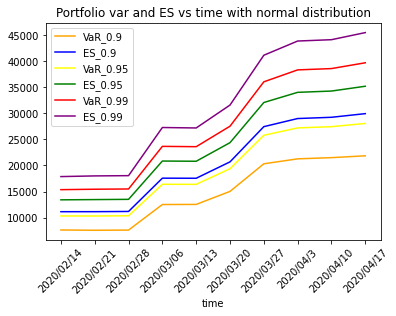

(array([ 7634.82594937,  7574.98275268,  7613.86152442, 12515.53549932,
       12533.28364723, 15031.90255789, 20326.56294414, 21275.09030523,
       21505.46557282, 21859.66435806]), array([11137.7674417 , 11142.82405831, 11185.52937477, 17569.44844854,
       17550.98837999, 20698.4402528 , 27450.8239525 , 29006.6084409 ,
       29246.68153011, 29944.85843539]), array([10322.91320796, 10312.87283031, 10354.68801595, 16393.80724168,
       16383.76992827, 19380.29028043, 25793.5783897 , 27208.10272796,
       27445.91990995, 28064.08062654]), array([13414.67088969, 13461.91222706, 13507.10478827, 20854.47957027,
       20812.4842491 , 24381.67596881, 32081.57627588, 34032.07641968,
       34278.45306936, 35200.21491582]), array([15365.31785415, 15448.69928239, 15496.02269215, 23668.80004198,
       23606.64182409, 27537.14247541, 36048.79015611, 38337.44732442,
       38589.22430017, 39702.53370093]), array([17872.60422721, 18002.43873434, 18052.50105466, 27286.21902997,
       27198.

In [35]:
PL=Portloss_N()
print(PL)
PL_N=plot_N(PL)
print(PL_N)

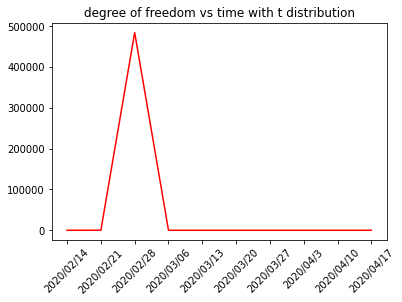

In [41]:
x=['2020/02/14','2020/02/21','2020/02/28','2020/03/06','2020/03/13','2020/03/20','2020/03/27','2020/04/3','2020/04/10','2020/04/17']

df=PL2[0]
mu=PL2[1]
sigma=PL2[2]
#sigma=np.sqrt(np.array(PL[1]))
plt.plot(x,df,'r')
#plt.plot(x,mu,'g')
#plt.plot(x,sigma,'b')
plt.title('degree of freedom vs time with t distribution')
#plt.legend()
plt.xticks(rotation=45)
plt.show()


In [0]:
df=PL2[0]

([113694.66400486755, 980673.3008934641, 483936.8444122916, 2.885552559850729, 2.745257065499576, 2.257496742387682, 1.8102192908406765, 1.6023056287307447, 1.69256033984441, 1.6133213364232923], [-1846.8478482548708, -2082.6231453172377, -2053.9967077114698, -2552.652281298696, -2475.4639469730328, -2558.8557356452675, -2526.2043191877137, -2410.962116506458, -2112.051383721987, -2029.163422594597], [7399.855359337031, 7536.775438576061, 7544.712976686999, 5934.93004676967, 5711.589967883633, 5752.9910268071635, 5781.235823895155, 5740.154041846767, 6113.042815904214, 6346.480500598108])


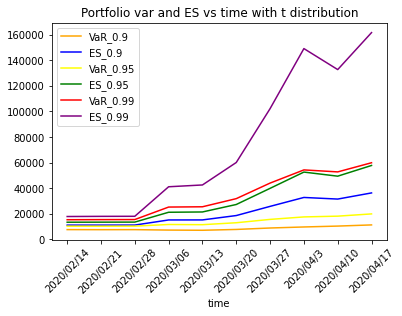

In [50]:
PL2=Portloss_T()
print(PL2)
PL_T=plot_T(PL2)



In [51]:
print(PL_T)

([7636.503472887573, 7576.149723416364, 7614.955217661994, 7272.234400486347, 7117.901333706915, 7764.555137062705, 8896.796814501755, 9701.883374848465, 10396.463832347217, 11310.110238274938], [11139.907444337003, 11144.30770411767, 11186.88048080221, 15180.286407428506, 15214.242232226854, 18630.07363228083, 25802.38535134719, 32777.70965164145, 31514.869192155416, 36322.74769001529], [10324.930254306246, 10314.280980988278, 10355.975552339914, 11643.154336627878, 11490.040066861297, 13003.314334352794, 15626.00464690748, 17562.32451378925, 18158.122632757797, 19917.037474593504], [13417.120076583751, 13463.60271285828, 13508.625260672983, 21201.35345237173, 21428.63864294985, 27270.088497113058, 39900.99423449092, 52613.295528423776, 49416.15026852526, 57784.93857293353], [15368.032646471467, 15450.567032462834, 15497.688423364503, 25269.649725486794, 25485.1650169241, 31846.427604682285, 44015.28166161229, 54309.30219004919, 52760.359031242224, 59910.48312102435], [17875.716689746

In [0]:
testt=getdata1('PORT_VALUE',0)[1]
print(testt)


In [0]:
#print(BB2)

In [0]:
p=c*(np.exp(-r)-np.exp(-17*r))/(1-np.exp(-r))+F*np.exp(-16*r)
print(p)

In [0]:
p2=c*(1-(1+r)**(-n))/r+F/((1+r)**n)
print(p2)